# Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Load Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving goldstock.csv to goldstock (1).csv


In [ ]:
df = pd.read_csv("goldstock.csv")
df.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Date        2511 non-null   object 
 2   Close       2511 non-null   float64
 3   Volume      2511 non-null   float64
 4   Open        2511 non-null   float64
 5   High        2511 non-null   float64
 6   Low         2511 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.4+ KB


In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
Date,0
Close,0
Volume,0
Open,0
High,0
Low,0


# PreProcessing

In [ ]:
# Mengubah tipedata
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [ ]:
# Menghapus kolom Unnamed
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2511 entries, 2510 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2511 non-null   datetime64[ns]
 1   Close   2511 non-null   float64       
 2   Volume  2511 non-null   float64       
 3   Open    2511 non-null   float64       
 4   High    2511 non-null   float64       
 5   Low     2511 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 137.3 KB


In [ ]:
df.describe()

,Date,Close,Volume,Open,High,Low
count,2511,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,2019-01-17 07:28:27.526881792,1498.726085,185970.770609,1498.725528,1508.451454,1488.869932
min,2014-01-22 00:00:00,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,2016-07-19 12:00:00,1249.850000,126693.500000,1249.500000,1257.300000,1242.350000
50%,2019-01-17 00:00:00,1332.800000,175421.000000,1334.000000,1342.400000,1326.600000
75%,2021-07-17 12:00:00,1805.850000,234832.000000,1805.600000,1815.450000,1793.050000
max,2024-01-19 00:00:00,2093.100000,787217.000000,2094.400000,2098.200000,2074.600000
std,NaN,298.824811,97600.769382,299.118187,301.262244,296.417703


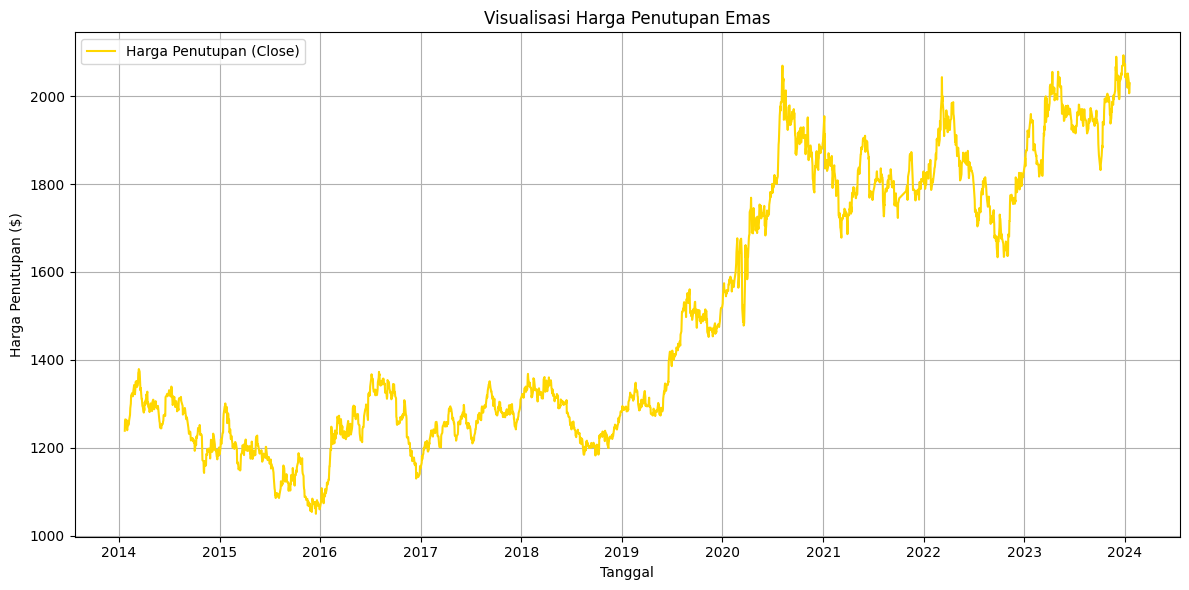

In [ ]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Harga Penutupan (Close)', color='gold')
plt.title('Visualisasi Harga Penutupan Emas')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Memisahkan target dan fitur
target = df[['Close']].values  # target harga Close
features = df[['Volume', 'Open', 'High', 'Low']].values  # fitur lainnya

# Scalling

In [ ]:
scaler_close = MinMaxScaler()
target_scaled = scaler_close.fit_transform(target)

In [ ]:

scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)

In [ ]:
scaled_data = np.hstack((target_scaled, features_scaled))

In [ ]:
#sequences untuk multi-step forecasting
def create_sequences_multi_step(data, look_back=30, forecast_horizon=30):
    X, y = [], []
    for i in range(look_back, len(data) - forecast_horizon + 1):
        X.append(data[i - look_back:i])
        y.append(data[i:i + forecast_horizon, 0])  # target kolom 0 = Close price
    return np.array(X), np.array(y)

look_back = 30
forecast_horizon = 30

X, y = create_sequences_multi_step(scaled_data, look_back, forecast_horizon)

In [ ]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
#cek shape data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1961, 30, 5)
y_train shape: (1961, 30)


# LSTM

In [ ]:
# Build model LSTM
model = Sequential([
    LSTM(100, activation='relu', input_shape=(look_back, X.shape[2])),
    Dropout(0.2),
    Dense(forecast_horizon)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 100)            │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,430 (177.46 KB)

 Trainable params: 45,430 (177.46 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0432 - mae: 0.1577 - val_loss: 0.0226 - val_mae: 0.1187
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0051 - mae: 0.0538 - val_loss: 0.0443 - val_mae: 0.1742
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0041 - mae: 0.0476 - val_loss: 0.0415 - val_mae: 0.1717
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0036 - mae: 0.0451 - val_loss: 0.0067 - val_mae: 0.0655
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0033 - mae: 0.0432 - val_loss: 0.0111 - val_mae: 0.0859
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0030 - mae: 0.0416 - val_loss: 0.0129 - val_mae: 0.0930
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0028 - mae: 0.0404 - val_loss: 0.0074 - val_mae: 0.0693
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027 - mae: 0.0391 - val_loss: 0.0068 - val_mae: 0.0665
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.002

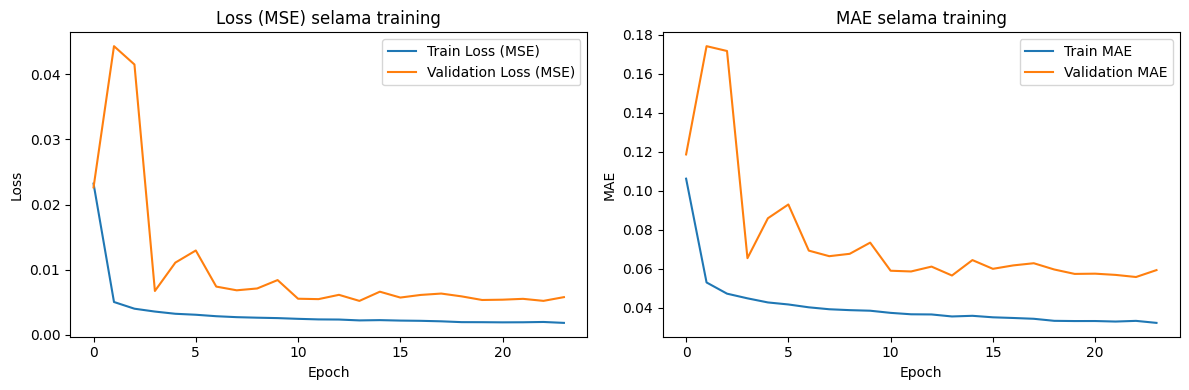

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Loss (MSE) selama training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE selama training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#inverse
def inverse_transform_forecast(scaler, data):
    data_reshaped = data.reshape(-1,1)
    data_inv = scaler.inverse_transform(data_reshaped)
    return data_inv.reshape(data.shape)

In [ ]:
#prediksi
y_pred = model.predict(X_test)
y_pred_inv = inverse_transform_forecast(scaler_close, y_pred)
y_test_inv = inverse_transform_forecast(scaler_close, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


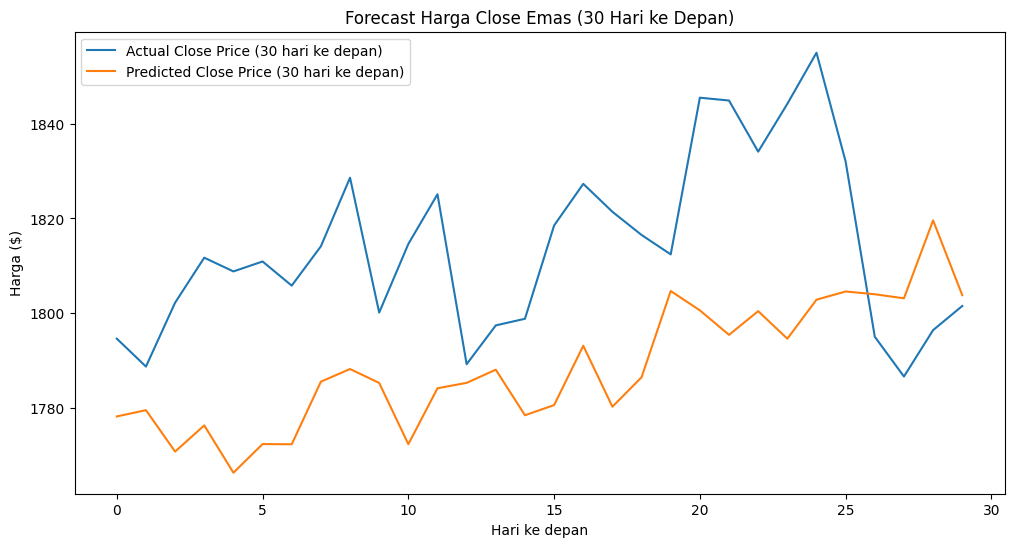

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[0], label='Actual Close Price (30 hari ke depan)')
plt.plot(y_pred_inv[0], label='Predicted Close Price (30 hari ke depan)')
plt.title('Forecast Harga Close Emas (30 Hari ke Depan)')
plt.xlabel('Hari ke depan')
plt.ylabel('Harga ($)')
plt.legend()
plt.show()